# Kaggle:Yelp:Images
## Create data/train_imgids.csv from data/train.csv & data/train_photo_to_biz.csv
### bdanalytics

In [72]:
format(Sys.time(), "(%a) %b %d, %Y")

[1] "(Wed) Feb 03, 2016"

In [134]:
require(doMC)
glbCores <- 6 # of cores on machine - 2
registerDoMC(glbCores)

require(dplyr)
require(ggplot2)
require(jpeg)
require(reshape2)
source("~/Dropbox/datascience/R/myplot.R")

### Import data files

In [74]:
obsTrn <- read.csv("data/train.csv")
obsTrnImgBiz <- read.csv("data/train_photo_to_biz_ids.csv")
obsNew <- read.csv("data/test.csv")
obsNewImgBiz <- read.csv("data/test_photo_to_biz.csv")

Create separate dataframes for all observations 
    - obsAll:       non-images data
    - obsAllImgBiz: photo_id to biz_id only
    - obsAllImg:    images only

In [75]:
obsTrn$.src <- "Train"; obsTrnImgBiz$.src <- "Train"
obsNew$.src <- "Test" ; obsNewImgBiz$.src <- "Test"

obsAll <- myrbind_df(obsTrn, obsNew)
print("obsAll:")
print(table(obsAll$.src, useNA = "ifany"))
print(" ")
print("obsAllImgBiz:")
obsAllImgBiz <- myrbind_df(obsTrnImgBiz, obsNewImgBiz)
print(table(obsAllImgBiz$.src, useNA = "ifany"))

[1] "obsAll:"

 Test Train 
10000  2000 
[1] " "
[1] "obsAllImgBiz:"

   Test   Train 
1190225  234842 


In [93]:
obsAllImg <- obsAllImg[, c('photo_id', '.src'), FALSE]
print(table(obsAllImg$.src, useNA = "ifany"))
obsAllImg <- dplyr::distinct(obsAllImg, photo_id)
print(table(obsAllImg$.src, useNA = "ifany"))


   Test   Train 
1190225  234842 

  Test  Train 
237152 234842 


### Inspect data

How many (& Which) businesses are duplicated across Train & Test ?

In [77]:
obsAllDups <- gdata::duplicated2(obsAll$business_id)
print(table(obsAllDups, obsAll$.src, useNA = "ifany"))

          
obsAllDups  Test Train
     FALSE 10000  2000


How many (& Which) images are duplicated across Train & Test ?

In [95]:
obsAllImgDups <- gdata::duplicated2(obsAllImg)
print(nrow(obsAllImgDups))
#print(table(obsAllImgDups, obsAllImgBiz$.src, useNA = "ifany"))

NULL


Which images are duplicated (chain - chn) across restaurants ?

In [78]:
obsAllImgBiz$chn <- gdata::duplicated2(obsAllImgBiz$photo_id)
print(table(obsAllImgBiz$chn, obsAllImgBiz$.src, useNA = "ifany"))

       
           Test   Train
  FALSE    4325  234842
  TRUE  1185900       0


In [79]:
obsAllImgBiz[obsAllImgBiz$chn & obsAllImgBiz$.src == "Test", ] %>%
    dplyr::count(photo_id) %>%
    arrange(desc(n)) %>%
    head() %>%
    print()

Source: local data frame [6 x 2]

  photo_id     n
     (int) (int)
1    91974    16
2   182938    16
3   235151    16
4   426819    16
5     7545    15
6    24198    15


ERROR: Error in file(con, "rb"): cannot open the connection


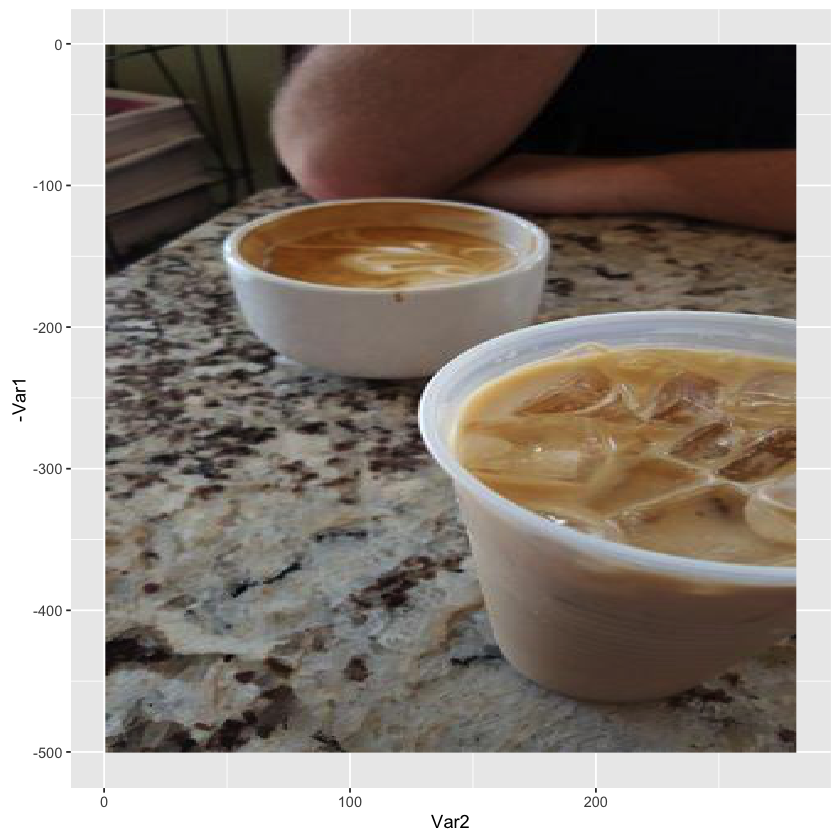

In [80]:
print(myplotImg(img <- readJPEG("data/photos/91974.jpg")))

ERROR: Error in file(con, "rb"): cannot open the connection


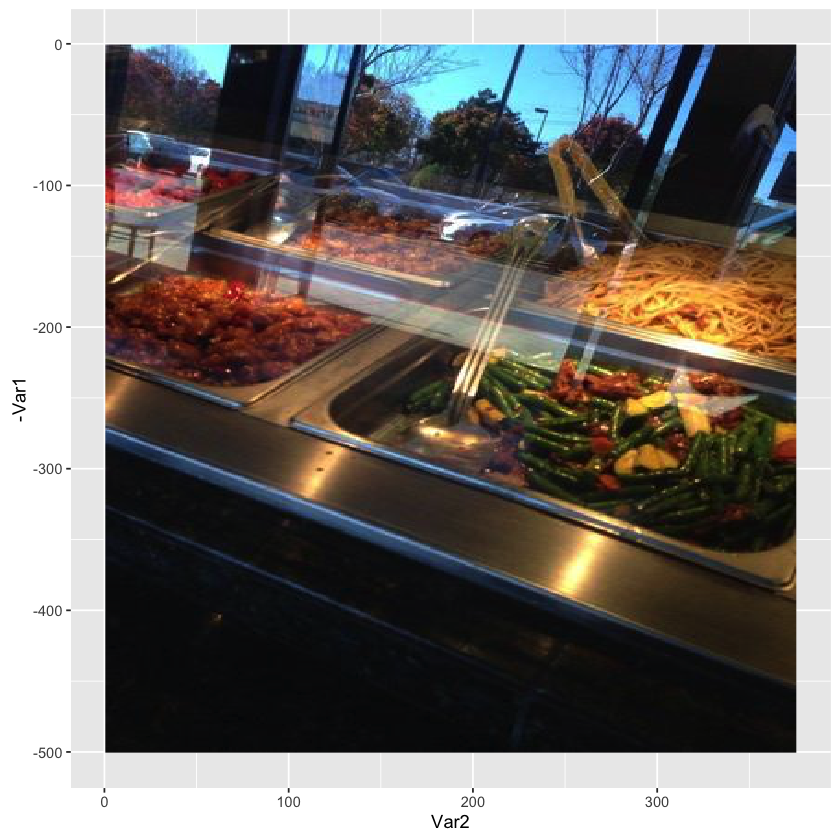

In [81]:
print(myplotImg(img <- readJPEG("data/photos/182938.jpg")))

ERROR: Error in file(con, "rb"): cannot open the connection


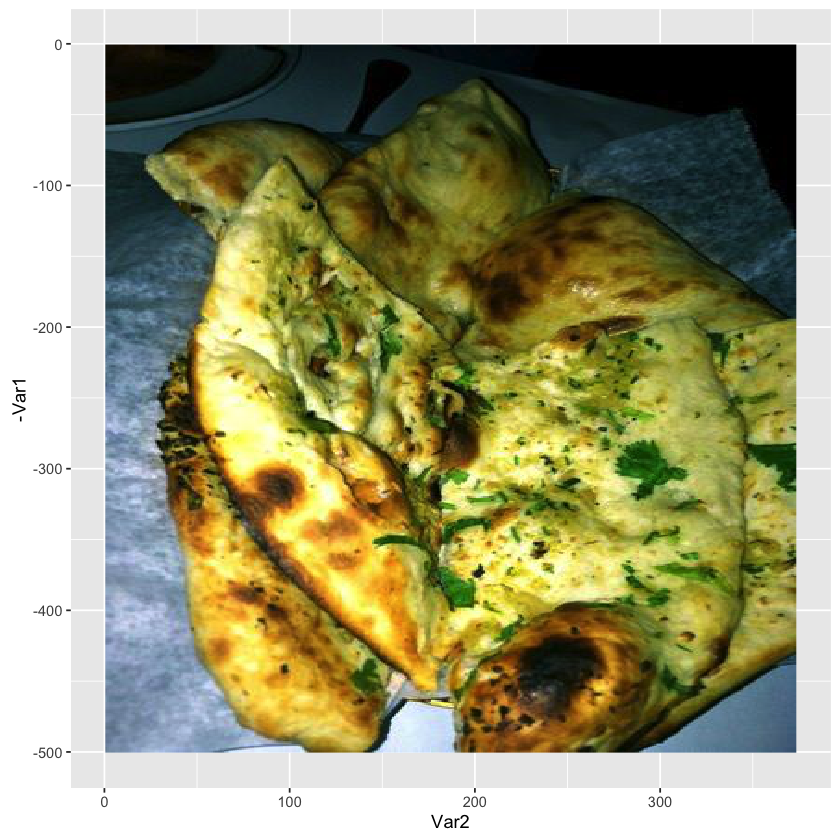

In [82]:
print(myplotImg(img <- readJPEG("data/photos/235151.jpg")))

ERROR: Error in file(con, "rb"): cannot open the connection


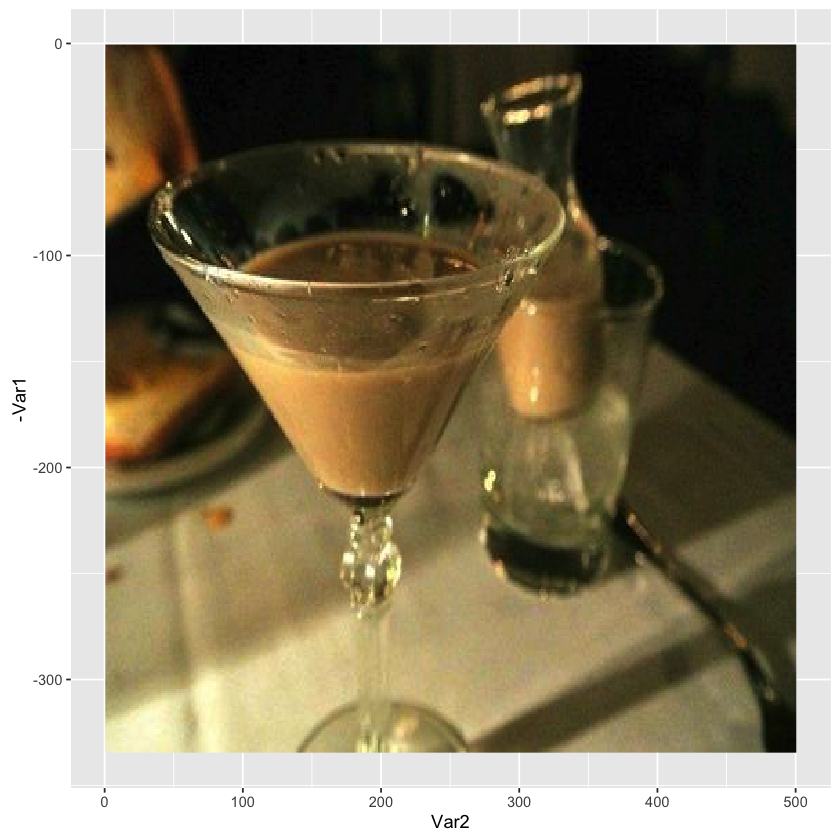

In [83]:
print(myplotImg(img <- readJPEG("data/photos/426819.jpg")))

In [84]:
print(class(img)); print(dim(img))
print(img[1:5, 1:5, 1])

[1] "array"
[1] 334 500   3
          [,1]      [,2]      [,3]      [,4]      [,5]
[1,] 0.3921569 0.3686275 0.3333333 0.3254902 0.3254902
[2,] 0.4196078 0.3960784 0.3607843 0.3450980 0.3372549
[3,] 0.4352941 0.4117647 0.3843137 0.3686275 0.3529412
[4,] 0.4117647 0.4000000 0.3921569 0.3764706 0.3725490
[5,] 0.4000000 0.3960784 0.3921569 0.3843137 0.3764706


### Summarize Image data to businesses

#### nImgs

In [85]:
nImgsAll <-
    #obsAllImgBiz[1:10, c("photo_id", "business_id")] %>%
    obsAllImgBiz[, c("photo_id", "business_id")] %>%
    dplyr::group_by(business_id) %>%
    dplyr::summarize(nImgs = n_distinct(photo_id))

print(summary(nImgsAll$nImgs))
print(tapply(nImgsAll$nImgs, obsAll$.src, FUN = summary))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    32.0    60.0   118.8   120.0  2974.0 
$Test
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1      32      59     118     120    2825 

$Train
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    33.0    61.5   122.4   121.0  2974.0 



In [86]:
obsAll <- dplyr::left_join(obsAll, nImgsAll)
print(tapply(obsAll$nImgs, obsAll$.src, summary))
myprint_df(obsAll)

Joining by: "business_id"


$Test
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1      32      60     119     120    2825 

$Train
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0    34.0    61.0   117.4   117.0  2974.0 

  business_id        labels  .src nImgs
1        1000 1 2 3 4 5 6 7 Train    54
2        1001       0 1 6 8 Train     9
3         100   1 2 4 5 6 7 Train    84
4        1006     1 2 4 5 6 Train    22
5        1010         0 6 8 Train    11
6         101   1 2 3 4 5 6 Train   121
      business_id          labels  .src nImgs
1492          371 1 2 3 4 5 6 7 8 Train    44
4815        a0llc            <NA>  Test     7
7643        k8s6m            <NA>  Test    41
8139        lz1v5            <NA>  Test   386
9039        p9vdc            <NA>  Test   144
11777       z7hxq            <NA>  Test    69
      business_id labels .src nImgs
11995       zyrif   <NA> Test    89
11996       zyvg6   <NA> Test    16
11997       zyvjj   <NA> Test    27
11998       zz8g4   <NA> Test   118
11999  

#### resX, resY, resXY

In [111]:
#savobsAllImg <- obsAllImg; print(all.equal(savobsAllImg, obsAllImg))

[1] TRUE


In [143]:
#obsAllImg <- savobsAllImg

In [144]:
startTm <- proc.time()["elapsed"]
nImages <- nrow(obsAllImg) 
ftsAllImg <- foreach(imgIx = 1:nImages, .combine = rbind) %dopar% {
    img <- readJPEG(sprintf("data/photos/%d.jpg", 
                            obsAllImg[imgIx, 'photo_id']))
    ftsThsImg <- data.frame('resY'  = dim(img)[1],
                            'resX'  = dim(img)[2],
                            'resXY' = dim(img)[2] * dim(img)[1])    
}
#print(ftsAllImg)
obsAllImg <- cbind(obsAllImg[1:nImages, setdiff(names(obsAllImg), 
                            grep("res", names(obsAllImg), value = TRUE))], 
                   ftsAllImg)
#myprint_df(obsAllImg)
print(sprintf("Finished reading images:%d elapsed seconds:%0.0f",
      sum(obsAllImg[, 'resX'] > -1), proc.time()["elapsed"] - startTm))

[1] "Finished reading images:471994 elapsed seconds:27614"


In [145]:
myprint_df(obsAllImg)

  photo_id  .src resY resX  resXY
1   204149 Train  500  373 186500
2    52779 Train  500  500 250000
3   278973 Train  375  500 187500
4   195284 Train  375  500 187500
5    19992 Train  375  500 187500
6    80748 Train  375  500 187500
       photo_id  .src resY resX  resXY
212160   255145 Train  375  500 187500
224936   353269 Train  373  500 186500
303031   215485  Test  500  375 187500
325723   420646  Test  375  500 187500
338406    27534  Test  500  373 186500
453103   155686  Test  500  375 187500
       photo_id .src resY resX  resXY
471989    87954 Test  375  500 187500
471990   157255 Test  373  500 186500
471991   164647 Test  500  500 250000
471992   439142 Test  500  373 186500
471993   297463 Test  500  281 140500
471994   274169 Test  500  375 187500


In [142]:
# all.equal(savobsAllImg[1:2000, c('photo_id','.src','resY','resX','resXY')], 
#           obsAllImg[         , c('photo_id','.src','resY','resX','resXY')])

[1] TRUE

In [146]:
print(nrow(obsAllImg))

[1] 471994


In [176]:
print(summary(obsAllImg))

    photo_id          .src                resY            resX      
 Min.   :     1   Length:471994      Min.   : 29.0   Min.   : 53.0  
 1st Qu.:117999   Class :character   1st Qu.:375.0   1st Qu.:375.0  
 Median :235998   Mode  :character   Median :428.0   Median :500.0  
 Mean   :235998                      Mean   :427.4   Mean   :440.6  
 3rd Qu.:353996                      3rd Qu.:500.0   3rd Qu.:500.0  
 Max.   :471994                      Max.   :500.0   Max.   :500.0  
     resXY       
 Min.   :  1802  
 1st Qu.:186500  
 Median :187500  
 Mean   :184589  
 3rd Qu.:187500  
 Max.   :250000  


In [177]:
print(tapply(obsAllImg$resX, obsAllImg$.src, FUN = summary))

$Test
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   53.0   375.0   500.0   440.6   500.0   500.0 

$Train
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   61.0   375.0   500.0   440.5   500.0   500.0 



In [178]:
print(tapply(obsAllImg$resY, obsAllImg$.src, FUN = summary))

$Test
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   29.0   375.0   437.0   427.5   500.0   500.0 

$Train
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   29.0   375.0   419.0   427.3   500.0   500.0 



In [179]:
print(tapply(obsAllImg$resXY, obsAllImg$.src, FUN = summary))

$Test
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1802  186500  187500  184600  187500  250000 

$Train
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3675  186500  187500  184500  187500  250000 



Warning message:
In myplot_violin(obsAllImg, c("resX", "resY"), ".src"): xcol_name:.src is not a factor; creating .src_fctrWarning message:
In myplot_violin(obsAllImg, c("resXY"), ".src"): xcol_name:.src is not a factor; creating .src_fctr

ERROR: Error in file(con, "rb"): cannot open the connection


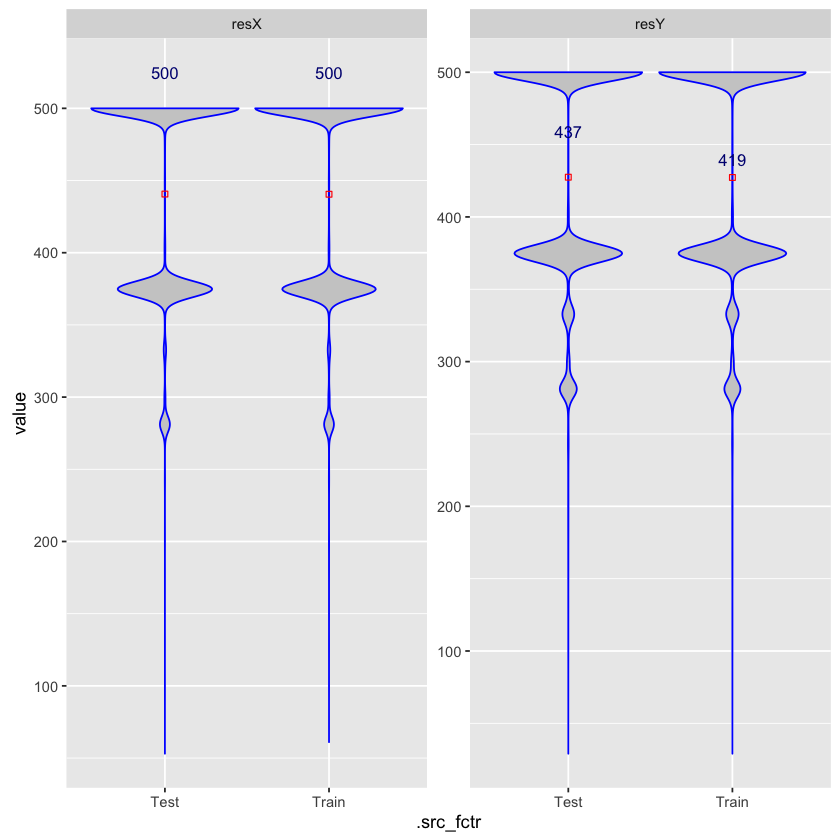

ERROR: Error in file(con, "rb"): cannot open the connection


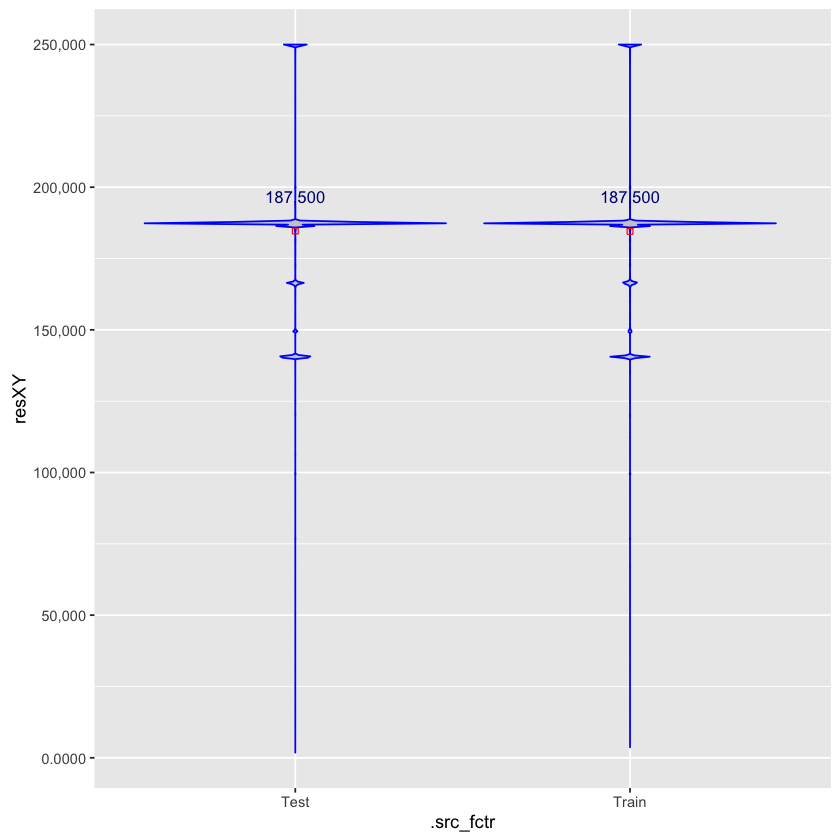

In [171]:
print(myplot_violin(obsAllImg, c("resX", "resY"), ".src"))
print(myplot_violin(obsAllImg, c("resXY"), ".src"))

In [167]:
source("~/Dropbox/datascience/R/myplot.R")
require(Cairo)

Loading required package: Cairo


[1] "Sample images for min.resX:"
[1] "  nrow(smpImgs): 1"
       photo_id .src resY resX resXY
260002   463232 Test   34   53  1802
[1] "Sample images for max.resX:"
[1] "  nrow(smpImgs): 264119"
       photo_id .src resY resX  resXY
361532   201900 Test  500  500 250000
       photo_id .src resY resX  resXY
348637   188828 Test  375  500 187500


Warning message:
In svg(tf, width, height, pointsize, FALSE, family, bg, antialias): failed to load cairo DLLWarning message:
In file(con, "rb"): cannot open file '/var/folders/g8/rqv40nhs3zqcntnz_9t9l60w0000gr/T//Rtmpj9lQya/file532b3ec6ead8.svg': No such file or directory

ERROR: Error in file(con, "rb"): cannot open the connection


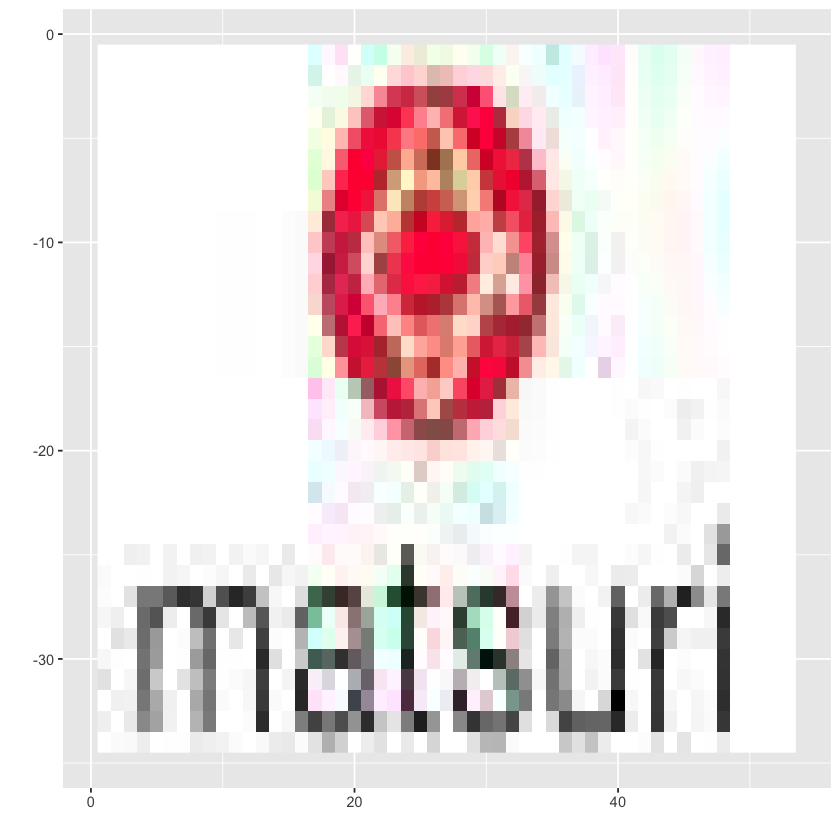

      photo_id  .src resY resX  resXY
21181   255121 Train  500  500 250000
[1] "Sample images for min.resY:"
[1] "  nrow(smpImgs): 2"
      photo_id  .src resY resX resXY
24939   290501 Train   29  500 14500
       photo_id .src resY resX resXY
386220   428032 Test   29  156  4524
[1] "Sample images for max.resY:"
[1] "  nrow(smpImgs): 231543"
       photo_id  .src resY resX  resXY
163828   143057 Train  500  500 250000
       photo_id  .src resY resX  resXY
193600   180018 Train  500  281 140500
       photo_id  .src resY resX  resXY
165822   157910 Train  500  375 187500
[1] "Sample images for min.resXY:"
[1] "  nrow(smpImgs): 1"
       photo_id .src resY resX resXY
260002   463232 Test   34   53  1802
[1] "Sample images for max.resXY:"
[1] "  nrow(smpImgs): 31398"
       photo_id .src resY resX  resXY
328430   144996 Test  500  500 250000
       photo_id .src resY resX  resXY
307842   201150 Test  500  500 250000
       photo_id .src resY resX  resXY
323016   208342 Test  500  500 

ERROR: Error in file(con, "rb"): cannot open the connection


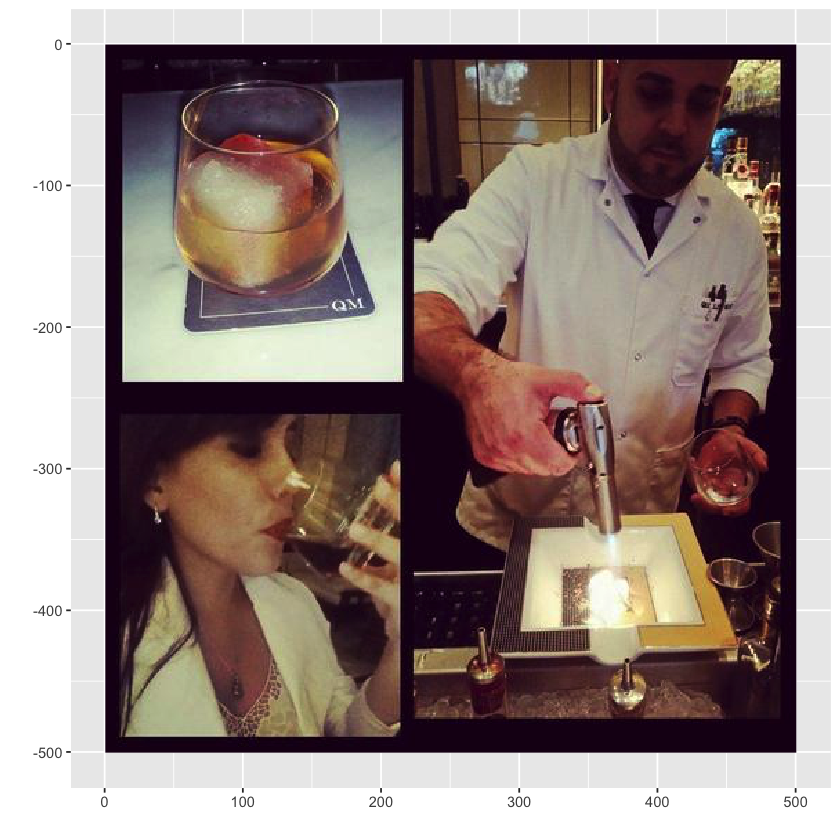

In [169]:
for (feat in c('resX', 'resY', 'resXY')) {
    for (stat in c('min', 'max')) {
        print(sprintf("\nSample images for %s.%s:", stat, feat))
        statVal <- if (stat == 'min') min(obsAllImg[, feat]) else
                                      max(obsAllImg[, feat])
        smpImgs <- obsAllImg[obsAllImg[, feat] == statVal, ]
        print(sprintf("  nrow(smpImgs): %d", nrow(smpImgs)))
        if (nrow(smpImgs) > 3)
            smpImgs <- smpImgs[sample(1:nrow(smpImgs), 3), ]
        for (ix in 1:nrow(smpImgs)) {
            print(smpImgs[ix, ])
            print(myplotImg(img <- readJPEG(sprintf("data/photos/%d.jpg", 
                                                smpImgs[ix, 'photo_id']))))
        }
    }
}        

In [181]:
resAllImgBiz <- dplyr::full_join(obsAllImgBiz, obsAllImg)

Joining by: c("photo_id", ".src")


In [183]:
print(nrow(obsAllImgBiz))
print(nrow(resAllImgBiz))

[1] 1425067
[1] 1425067


In [184]:
myprint_df(resAllImgBiz)

  photo_id business_id  .src   chn resY resX  resXY
1   204149        3034 Train FALSE  500  373 186500
2    52779        2805 Train FALSE  500  500 250000
3   278973         485 Train FALSE  375  500 187500
4   195284         485 Train FALSE  375  500 187500
5    19992         485 Train FALSE  375  500 187500
6    80748         485 Train FALSE  375  500 187500
        photo_id business_id  .src   chn resY resX  resXY
29958     275601        2777 Train FALSE  375  500 187500
368778    167468       3yksr  Test  TRUE  375  500 187500
959253    376511       ls8tq  Test  TRUE  375  500 187500
1017355   219664       nnu59  Test  TRUE  500  375 187500
1021417   422010       nutpn  Test  TRUE  375  500 187500
1101309   431510       q6npi  Test  TRUE  375  500 187500
        photo_id business_id .src  chn resY resX  resXY
1425062   141358       zzxwm Test TRUE  500  375 187500
1425063   219588       zzxwm Test TRUE  500  375 187500
1425064   331865       zzxwm Test TRUE  211  218  45998
142506

In [191]:
dupsImg <- 
    obsAllImgBiz[gdata::duplicated2(obsAllImgBiz[, 'photo_id', FALSE]), 
                ] %>%
    dplyr::arrange(photo_id)
dupsImg <- resAllImgBiz[resAllImgBiz$photo_id %in% 
                        unique(dupsImg[, 'photo_id']), ] %>%
    dplyr::arrange(photo_id)
myprint_df(dupsImg)

  photo_id business_id .src  chn resY resX  resXY
1        1       3tv9h Test TRUE  375  500 187500
2        1       4udt2 Test TRUE  375  500 187500
3        1       6ou8e Test TRUE  375  500 187500
4        1       jce1v Test TRUE  375  500 187500
5        1       lxz32 Test TRUE  375  500 187500
6        1       y1yxy Test TRUE  375  500 187500
        photo_id business_id .src  chn resY resX  resXY
82226      32713       yhjv2 Test TRUE  500  375 187500
592502    236595       l7sg8 Test TRUE  281  500 140500
664323    265155       ln3g5 Test TRUE  500  281 140500
731729    291738       aw9o5 Test TRUE  500  375 187500
986646    392623       g07bi Test TRUE  299  500 149500
1015680   404297       953i0 Test TRUE  299  500 149500
        photo_id business_id .src  chn resY resX  resXY
1185895   471985       zfnxq Test TRUE  375  500 187500
1185896   471989       79ur1 Test TRUE  500  500 250000
1185897   471989       7irkb Test TRUE  500  500 250000
1185898   471992       7dk49 Test 

In [192]:
dupsBiz <- 
    obsAllImgBiz[gdata::duplicated2(obsAllImgBiz[, 'business_id', FALSE]), 
                ] %>%
    dplyr::arrange(business_id)
dupsBiz <- resAllImgBiz[resAllImgBiz$business_id %in% 
                        unique(dupsBiz[, 'business_id']), ] %>%
    dplyr::arrange(business_id)
myprint_df(dupsBiz)

  photo_id business_id .src  chn resY resX  resXY
1   317818       003sg Test TRUE  500  375 187500
2    30679       003sg Test TRUE  375  500 187500
3   455084       003sg Test TRUE  500  375 187500
4   371381       003sg Test TRUE  500  375 187500
5    86224       003sg Test TRUE  500  500 250000
6    36076       003sg Test TRUE  500  375 187500
        photo_id business_id  .src   chn resY resX  resXY
180419    349933        2562 Train FALSE  333  500 166500
226409    300657       2pnu5  Test  TRUE  500  375 187500
443750    361244       6one3  Test  TRUE  500  281 140500
533032     41465       90q7u  Test  TRUE  500  375 187500
1018934   252951       nq73g  Test  TRUE  500  500 250000
1222630   349995       u36ow  Test  TRUE  244  408  99552
        photo_id business_id .src  chn resY resX  resXY
1425053   141358       zzxwm Test TRUE  500  375 187500
1425054   219588       zzxwm Test TRUE  500  375 187500
1425055   331865       zzxwm Test TRUE  211  218  45998
1425056   312559    

In [194]:
nImgsMax <- dplyr::arrange(nImgsAll, desc(nImgs)) %>% head()
myprint_df(nImgsMax)

Source: local data frame [6 x 2]

  business_id nImgs
        (chr) (int)
1        2339  2974
2        1114  2901
3       1zuh9  2825
4       4wby9  2825
5       clr6m  2825
6       fh8b2  2825


In [216]:
#print(dim(resAllBiz))

[1] 6 3


In [217]:
resAllBiz <- resAllImgBiz %>%
    #dplyr::filter(business_id %in% nImgsMax$business_id) %>%
    dplyr::group_by(business_id) %>%
    dplyr::summarize(
        resXLst = do.call(paste0, list(c(resX), collapse = ',')),
        resYLst = do.call(paste0, list(c(resY), collapse = ',')))

print(dim(resAllBiz))
print(names(resAllBiz))
myprint_df(resAllBiz)
print(resAllBiz$resXLst[1])
print(resAllBiz$resYLst[1])

[1] 12000     3
[1] "business_id" "resXLst"     "resYLst"    
Source: local data frame [6 x 3]

  business_id
        (chr)
1       003sg
2       00er5
3       00kad
4       00mc6
5       00q7x
6       00v0t
Variables not shown: resXLst (chr), resYLst (chr)
Source: local data frame [6 x 3]

  business_id
        (chr)
1        2906
2       52kck
3       h428r
4       t9f0a
5       wfids
6       y0xq5
Variables not shown: resXLst (chr), resYLst (chr)
Source: local data frame [6 x 3]

  business_id
        (chr)
1       zyrif
2       zyvg6
3       zyvjj
4       zz8g4
5       zzxkg
6       zzxwm
Variables not shown: resXLst (chr), resYLst (chr)
[1] "375,500,375,375,500,375,500,500,500,500,500,281,500,500,500,373,375,500,375,373,375,500,500,375,500,500,375,279,500,375,500,500,375,500,375,500,375,500,375,350,375,500,500,375,500,500,500,500,375,500,500,500,500,373,500,500,500,500,375,500,500,375,500,375,500,281,281,375,500,500,500,373,373,375,375,500,500,500,500,375,500,375,375,500,500,375,5

In [219]:
obsAll <- dplyr::left_join(obsAll, resAllBiz)
print(dim(obsAll))
print(summary(obsAll)))
#print(tapply(obsAll, obsAll$.src, summary))
myprint_df(obsAll)

Joining by: c("business_id", "resXLst", "resYLst")


[1] 12000     6


ERROR: Error in tapply(obsAll, obsAll$.src, summary): arguments must have same length


  business_id        labels  .src nImgs
1        1000 1 2 3 4 5 6 7 Train    54
2        1001       0 1 6 8 Train     9
3         100   1 2 4 5 6 7 Train    84
4        1006     1 2 4 5 6 Train    22
5        1010         0 6 8 Train    11
6         101   1 2 3 4 5 6 Train   121
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              resXLst
1                                                                                                                                                                                                                                         

### Output data for classifiers

In [225]:
# write.table(subset(obsAll, .src == "Train", select = -.src),
#           "data/train_resXY.csv", row.names = FALSE, quote = TRUE, 
#           sep = ',')
write.csv(subset(obsAll, .src == "Train", select = -.src),
          "data/train_resXY.csv", row.names = FALSE)
write.csv(subset(obsAll, .src == "Test" , select = -.src) %>% 
          subset(select = -labels),
          "data/test_resXY.csv" , row.names = FALSE)

In [88]:
print(sessionInfo())
print(format(Sys.time(), "(%a) %b %d, %Y"))

R version 3.2.2 (2015-08-14)
Platform: x86_64-apple-darwin15.0.0 (64-bit)
Running under: OS X 10.11.3 (El Capitan)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] doBy_4.5-14     survival_2.38-3 reshape2_1.4.1  ggplot2_2.0.0  
[5] jpeg_0.1-8      dplyr_0.4.3    

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.3        nloptr_1.0.4       plyr_1.8.3         base64enc_0.1-3   
 [5] iterators_1.0.8    tools_3.2.2        rpart_4.1-10       lme4_1.1-10       
 [9] digest_0.6.9       uuid_0.1-2         jsonlite_0.9.19    evaluate_0.8      
[13] nlme_3.1-124       gtable_0.1.2       lattice_0.20-33    mgcv_1.8-11       
[17] Matrix_1.2-3       foreach_1.4.3      DBI_0.3.1          IRdisplay_0.3     
[21] IRkernel_0.5       parallel_3.2.2     SparseM_1.7        rzmq_0.7.7        
[25] repr_0.4           stringr_1.0.0      gtools_3